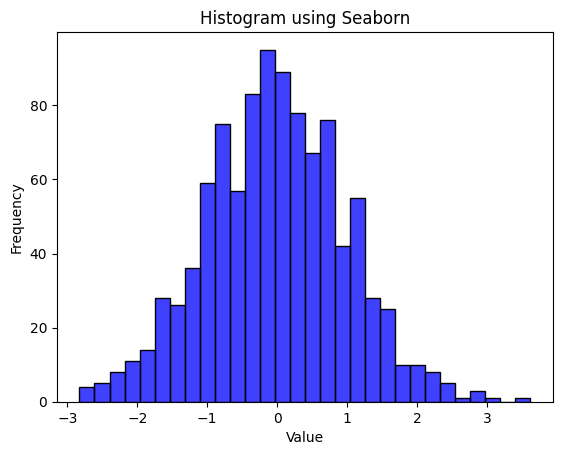

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
data = np.random.randn(1000)

# Create a histogram
sns.histplot(data, bins=30, kde=False, color='blue')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram using Seaborn')

# Show the plot
plt.show()



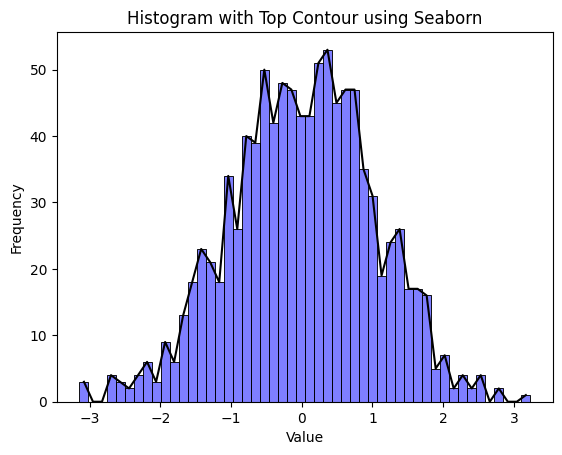

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
data = np.random.randn(1000)

# Create a histogram
ax = sns.histplot(data, bins=50, kde=False, color='blue', alpha=0.5)

# Extract the histogram data
counts, bins = np.histogram(data, bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Overlay a line plot (top contour)
sns.lineplot(x=bin_centers, y=counts, color='black', ax=ax)

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Top Contour using Seaborn')

# Show the plot
plt.show()


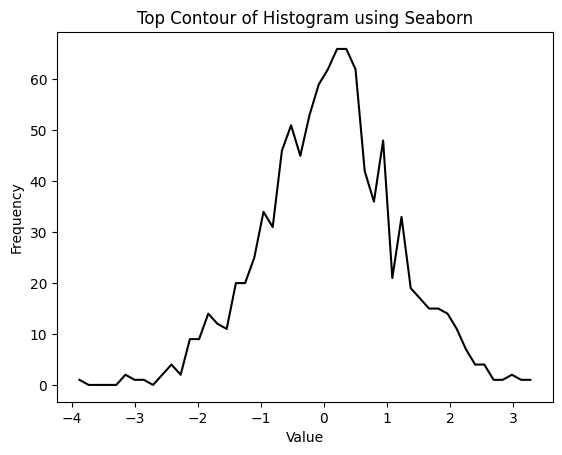

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
data = np.random.randn(1000)

# Compute the histogram data
counts, bins = np.histogram(data, bins=50)

# Calculate the bin centers
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Plot only the top contour using Seaborn
sns.lineplot(x=bin_centers, y=counts, color='black')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


Distribution of directed interaction weights inferred from Model RNN training:

In [1]:
import sys
import os
sys.path.append(os.path.abspath("C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code"))
import hdf5storage
import mat73
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math



import CURBD.curbd as curbd
import PyalData.pyaldata as pyaldata

In [2]:
data_dir_WTM350 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2" 
data_dir_WTM355 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2" 
data_dir_ASM351 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2" 
data_dir_ASM354 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2" 
data_dir_PSM365 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M365/PS-M365-pyaldata2" 
data_dir_PSM366 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M366/PS-M366-pyaldata2" 

In [3]:
# consider all models, and no thalamus: 

current_magn_strengths = {'WT-M350':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354, data_dir_PSM365, data_dir_PSM366]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>8 and df.dcn_spikes[0].shape[1]>8 and df.str_spikes[0].shape[1]>8:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat
(63, 1)
(63, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
Error for  WT-M350_session1.mat: 0.02219736024329448
Explained variance for  WT-M350_session1.mat: 0.9945910023056108
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M350_session2.mat: 0.010310143249461626
Explained variance for  WT-M350_session2.mat: 0.9968486572613706
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
Error for  WT-M350_session3.mat: 0.006038798575985701
Explained variance for  WT-M350_session3.mat: 

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
Error for  WT-M350_session4.mat: 0.01208815556766726
Explained variance for  WT-M350_session4.mat: 0.9974355662206763


KeyboardInterrupt: 

In [18]:
model['J']

array([[-0.12569711, -0.21403497,  0.08483633, ...,  0.16253665,
        -0.07385362, -0.24958939],
       [ 0.18912571, -0.1749574 ,  0.13126546, ...,  0.10270562,
        -0.15738156, -0.00138908],
       [-0.15648384,  0.59222916, -0.16077244, ..., -0.04423306,
         0.08908605, -0.24680814],
       ...,
       [-0.15174767,  0.13585472,  0.13486221, ..., -0.29702174,
         0.12870735,  0.00303888],
       [-0.1565668 ,  0.34301144,  0.24447642, ...,  0.07068384,
        -0.25287833,  0.26075955],
       [ 0.07842542, -0.2853898 ,  0.00773646, ..., -0.01556439,
        -0.14835456, -0.19569798]])

In [ ]:
for idx_trg in range(nRegions):
        in_trg = regions[idx_trg, 1]
        lab_trg = regions[idx_trg, 0]
        for idx_src in range(nRegions):
            in_src = regions[idx_src, 1]
            lab_src = regions[idx_src, 0]
            sub_J = J[in_trg, :][:, in_src]
            CURBD[idx_trg, idx_src] = sub_J.dot(RNN[in_src, :])

In [25]:
model["regions"]

array([['m1',
        array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])],
       ['dcn',
        array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
               31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
               48, 49, 50, 51, 52])                                               ],
       ['str', array([53, 54, 55, 56, 57, 58, 59, 60, 61, 62])]],
      dtype=object)

In [21]:
model['regions'][0][1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [26]:
# Isolate weights from m1 (source) to dcn (target):

np.shape(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]]) 

(39, 14)

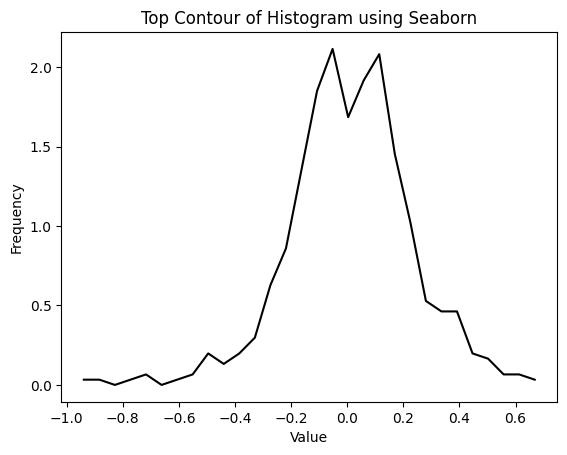

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the histogram data
counts, bins = np.histogram(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]], bins=30, density=True)  # density=True in order to normalise the histogram so that area under histogram is 1

# Calculate the bin centers
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Plot only the top contour using Seaborn
sns.lineplot(x=bin_centers, y=counts, color='black')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


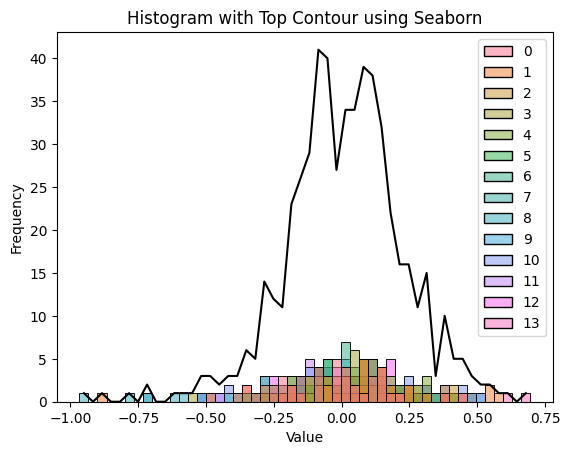

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram
ax = sns.histplot(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]], bins=50, kde=False, color='blue', alpha=0.5)

# Extract the histogram data
counts, bins = np.histogram(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]], bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Overlay a line plot (top contour)
sns.lineplot(x=bin_centers, y=counts, color='black', ax=ax)

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Top Contour using Seaborn')

# Show the plot
plt.show()


In [16]:
np.shape(model['J'])

(63, 63)

In [4]:
# consider all models, and no thalamus: 

current_magn_strengths = {'WT-M350':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM355]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in [files[4]]:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>8 and df.dcn_spikes[0].shape[1]>8 and df.str_spikes[0].shape[1]>8:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model_wtm355_13 = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session13.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\2893412092.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 

(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
Error for  WT-M355_session13.mat: 0.01208815556766726
Explained variance for  WT-M355_sessi

In [5]:
Nb

162

In [18]:
# consider all models, and no thalamus: 

current_magn_strengths = {'WT-M350':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM355]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in [files[4]]:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>8 and df.dcn_spikes[0].shape[1]>8 and df.str_spikes[0].shape[1]>8:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                number_dcn = int(np.shape(df.dcn_spikes[0])[1]/2)
                for i in range(len(df.dcn_spikes)):
                    df.dcn_spikes[i] = df.dcn_spikes[i][:,0:number_dcn]

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model_wtm355_13_subsampled = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session13.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4286799047.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
(180, 1)
Error for  WT-M355_session13.mat: 0.01208815556766726
Explained variance for  WT-M355_sessi

In [21]:
# consider all models, and no thalamus: 

current_magn_strengths = {'WT-M350':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM355]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in [files[4]]:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>8 and df.dcn_spikes[0].shape[1]>8 and df.str_spikes[0].shape[1]>8:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                number_dcn = int(np.shape(df.dcn_spikes[0])[1]/4)
                for i in range(len(df.dcn_spikes)):
                    df.dcn_spikes[i] = df.dcn_spikes[i][:,0:number_dcn]

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model_wtm355_13_subsampled2 = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session13.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\767883007.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
(139, 1)
Error for  WT-M355_session13.mat: 0.01208815556766726
Explained variance for  WT-M355_sessi

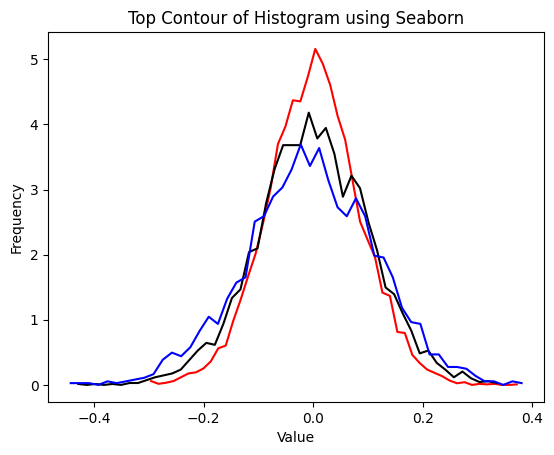

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the histogram data
counts, bins = np.histogram(model_wtm355_13["J"][model_wtm355_13["regions"][1][1],:][:,model_wtm355_13["regions"][0][1]], bins=50, density=True)  # density=True in order to normalise the histogram so that area under histogram is 1
counts2, bins2 = np.histogram(model_wtm355_13_subsampled["J"][model_wtm355_13_subsampled["regions"][1][1],:][:,model_wtm355_13_subsampled["regions"][0][1]], bins=50, density=True)  # density=True in order to normalise the histogram so that area under histogram is 1
counts3, bins3 = np.histogram(model_wtm355_13_subsampled2["J"][model_wtm355_13_subsampled2["regions"][1][1],:][:,model_wtm355_13_subsampled2["regions"][0][1]], bins=50, density=True)  # density=True in order to normalise the histogram so that area under histogram is 1


# Calculate the bin centers
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_centers2 = 0.5 * (bins2[1:] + bins2[:-1])
bin_centers3 = 0.5 * (bins3[1:] + bins3[:-1])

# Plot only the top contour using Seaborn
sns.lineplot(x=bin_centers, y=counts, color='red')
sns.lineplot(x=bin_centers2, y=counts2, color='black')
sns.lineplot(x=bin_centers3, y=counts3, color='blue')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


In [8]:
np.shape(df.dcn_rates[0])

(151, 162)

In [15]:
number_dcn = int(np.shape(df.dcn_rates[0])[1]/2)
for i in range(len(df.dcn_rates)):
    df.dcn_rates[i] = df.dcn_rates[i][:,0:number_dcn]

C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\336652490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dcn_rates[i] = df.dcn_rates[i][:,0:number_dcn]


In [16]:
np.shape(df.dcn_rates[0])

(151, 81)

In [11]:
number

array([[2.35556984e+01, 0.00000000e+00],
       [2.29483318e+01, 0.00000000e+00],
       [2.19867821e+01, 0.00000000e+00],
       [2.07230358e+01, 0.00000000e+00],
       [1.92097168e+01, 0.00000000e+00],
       [1.75049839e+01, 0.00000000e+00],
       [1.56786251e+01, 0.00000000e+00],
       [1.38160877e+01, 0.00000000e+00],
       [1.20177965e+01, 0.00000000e+00],
       [1.03934631e+01, 0.00000000e+00],
       [9.05171585e+00, 0.00000000e+00],
       [8.08721161e+00, 0.00000000e+00],
       [7.56802130e+00, 0.00000000e+00],
       [7.52516127e+00, 0.00000000e+00],
       [7.94622755e+00, 0.00000000e+00],
       [8.77463913e+00, 0.00000000e+00],
       [9.91452026e+00, 0.00000000e+00],
       [1.12414074e+01, 0.00000000e+00],
       [1.26177578e+01, 0.00000000e+00],
       [1.39114819e+01, 0.00000000e+00],
       [1.50149050e+01, 0.00000000e+00],
       [1.58609724e+01, 0.00000000e+00],
       [1.64335270e+01, 0.00000000e+00],
       [1.67689381e+01, 0.00000000e+00],
       [1.694802

In [13]:
number_dcn = np.shape(df.dcn_rates[0])[1]/2
number_dcn

81.0

In [ ]:
model_wtm355_13_subsampled

In [6]:
np.shape(avg_dcn_rates)

(151, 162)

In [ ]:
Nb

In [36]:
# consider all models, and no thalamus: 

current_magn_strengths = {'WT-M350':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_ASM351]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in [files[7]]:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>8 and df.dcn_spikes[0].shape[1]>8 and df.str_spikes[0].shape[1]>8:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model_asm351 = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session8.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\4172731505.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
Error for  AS-M351_session8.mat: 0.02345987161840539
Explained variance for  AS-M351_sessio

In [47]:
# consider all models, and no thalamus: 

current_magn_strengths = {'WT-M350':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[], 'dcn to m1':[], 'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_ASM351]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in [files[3]]:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>8 and df.dcn_spikes[0].shape[1]>8 and df.str_spikes[0].shape[1]>8:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model_asm351_2 = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\3104367525.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
Error for  AS-M351_session4.mat: 0.02345987161840539
Explained variance for  AS-M351_sessio

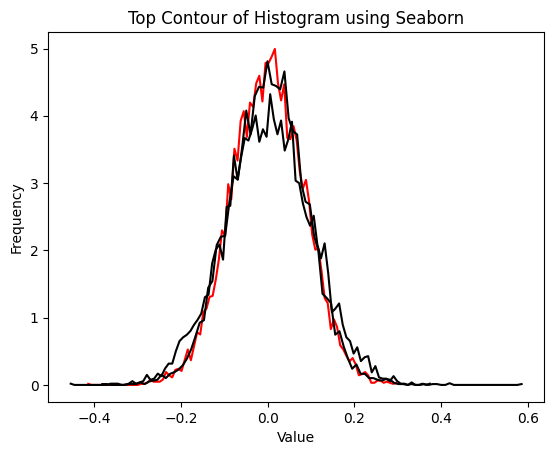

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the histogram data
counts, bins = np.histogram(model_wtm355_13["J"][model_wtm355_13["regions"][1][1],:][:,model_wtm355_13["regions"][0][1]], bins=100, density=True)  # density=True in order to normalise the histogram so that area under histogram is 1
counts_as, bins_as = np.histogram(model_asm351["J"][model_asm351["regions"][1][1],:][:,model_asm351["regions"][0][1]], bins=100, density=True)  # density=True in order to normalise the histogram so that area under histogram is 1
counts_as_2, bins_as_2 = np.histogram(model_asm351_2["J"][model_asm351_2["regions"][1][1],:][:,model_asm351_2["regions"][0][1]], bins=100, density=True)  # density=True in order to normalise the histogram so that area under histogram is 1


# Calculate the bin centers
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_centers_as = 0.5 * (bins_as[1:] + bins_as[:-1])
bin_centers_as_2 = 0.5 * (bins_as_2[1:] + bins_as_2[:-1])

# Plot only the top contour using Seaborn
sns.lineplot(x=bin_centers, y=counts, color='red')
sns.lineplot(x=bin_centers_as, y=counts_as, color='black')

sns.lineplot(x=bin_centers_as_2, y=counts_as_2, color='black')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


In [49]:
# consider all models, and no thalamus: 

weights_into_dcn = {'WT-M350':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]},
                'WT-M355':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]}, 
                'AS-M351':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]},
                'AS-M354':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>10 and df.dcn_spikes[0].shape[1]>10 and df.str_spikes[0].shape[1]>10:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                weights_into_dcn[animal_model]['m1 to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]])
                weights_into_dcn[animal_model]['dcn to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][1][1]])
                weights_into_dcn[animal_model]['str to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][2][1]])
                

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat
(63, 1)
(63, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
Error for  WT-M350_session1.mat: 0.01853635299046366
Explained variance for  WT-M350_session1.mat: 0.9958437057810183
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M350_session2.mat: 0.010253892705636005
Explained variance for  WT-M350_session2.mat: 0.9966522404109692
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
Error for  WT-M350_session3.mat: 0.005939680879649036
Explained variance for  WT-M350_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
Error for  WT-M350_session4.mat: 0.014112737102288792
Explained variance for  WT-M350_session4.mat: 0.9972411532746217
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M35

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
Error for  WT-M350_session5.mat: 0.017140306179302033
Explained variance for  WT-M350_session5.mat: 0.994718318437968
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
Error for  WT-M350_session6.mat: 0.01357085030106306
Explained variance for  WT-M350_sessio

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
Error for  WT-M355_session1.mat: 0.0016219957799983272
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1 

(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
Error for  WT-M355_session10.mat: 0.007741276610906548
Explained variance for  WT-M355_session10.mat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
Error for  WT-M355_session11.mat: 0.024653562232843228
Explained variance for  WT-M355_session11.mat: 0.9835462050983975
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3]

(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
Error for  WT-M355_session12.mat: 0.0030585492118671066
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 7

(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
Error for  WT-M355_session13.mat: 0.0027260429870015488
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [11

(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
Error for  WT-M355_session14.mat: 0.007196269459888386
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [6]

(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
Error for  WT-M355_session15.mat: 0.013603141150643564
Explained variance for  WT-M355_session15.mat: 0.9922341776261044
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism d

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
Error for  WT-M355_session17.mat: 0.01860578865705004
Explained variance for  WT-M355_session17.mat: 0.9835398908691715
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/a

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [13

(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
Error for  WT-M355_session18.mat: 0.002029663544648145
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4]

(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
Error for  WT-M355_session19.mat: 0.0021933234298184157
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
Error for  WT-M355_session2.mat: 0.0014552472222902893
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M355_session20.mat: 0.02043053098860503
Explained variance for  WT-M355_session20.mat: 0.9895830369763793
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/a

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
Error for  WT-M355_session21.mat: 0.012604265836872863
Explained variance for  WT-M355_session21.mat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
Error for  WT-M355_session23.mat: 0.002921844214840337
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
Error for  WT-M355_session3.mat: 0.0017053892327969825
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [31

(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
Error for  WT-M355_session4.mat: 0.0015952788927093584
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [35

(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
Error for  WT-M355_session5.mat: 0.0016600340514420014
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [10

(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
Error for  WT-M355_session6.mat: 0.002293086016224471
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [16

(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
Error for  WT-M355_session7.mat: 0.0030301778149275163
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1]

(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
Error for  WT-M355_session9.mat: 0.012958730240574418
Explained variance for  WT-M355_session9.mat: 0.9939102321640546
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism dat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
Error for  AS-M351_session1.mat: 0.0027368818502232863
Explained variance for  AS-M351_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
Error for  AS-M351_session2.mat: 0.002366109058605939
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
Error for  AS-M351_session3.mat: 0.003307694733385946
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [10

(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
Error for  AS-M351_session4.mat: 0.003986925090110654
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
Error for  AS-M351_session7.mat: 0.002898450445051309
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_18992\178050323.py:33: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1]

(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
Error for  AS-M351_session8.mat: 0.003135508883771417
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
Error for  AS-M354_session1.mat: 0.0038417779731218906
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
Error for  AS-M354_session2.mat: 0.003798483300279187
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
Error for  AS-M354_session4.mat: 0.0029199052178324296
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
Error for  AS-M354_session5.mat: 0.0026735479923174848
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
Error for  AS-M354_session6.mat: 0.0031378949435461336
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
Error for  AS-M354_session7.mat: 0.003980931136540267
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
Error for  AS-M354_session8.mat: 0.0038473154227197247
Explained variance for  AS-M354_session8.mat:

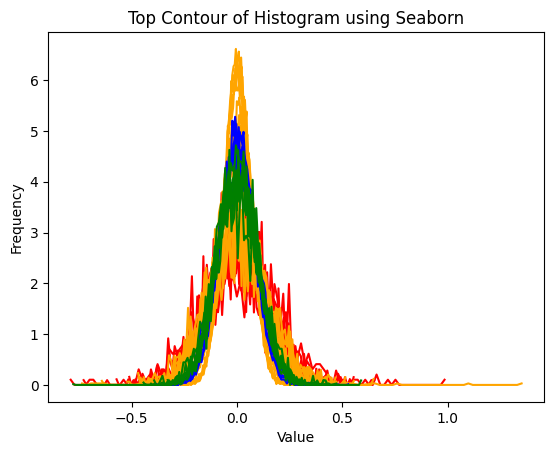

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


In [26]:
# consider all models, and no thalamus: 

weights_into_dcn = {'WT-M350':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]},
                'WT-M355':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]}, 
                'AS-M351':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]},
                'AS-M354':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>10 and df.dcn_spikes[0].shape[1]>10 and df.str_spikes[0].shape[1]>10:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                if animal_model=='AS-M351' or animal_model=='AS-M354':
                    number_dcn = int(np.shape(df.dcn_spikes[0])[1]/2)
                    for i in range(len(df.dcn_spikes)):
                        df.dcn_spikes[i] = df.dcn_spikes[i][:,0:number_dcn]

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                weights_into_dcn[animal_model]['m1 to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]])
                weights_into_dcn[animal_model]['dcn to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][1][1]])
                weights_into_dcn[animal_model]['str to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][2][1]])
                

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat
(63, 1)
(63, 1)
(63, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
Error for  WT-M350_session1.mat: 0.03078038812197591
Explained variance for  WT-M350_session1.mat: 0.991616722458503
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M350_session2.mat: 0.012421821615067644
Explained variance for  WT-M350_session2.mat: 0.9962172561205005
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
Error for  WT-M350_session3.mat: 0.00582495766005005
Explained variance for  WT-M350_session3.mat: 0

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
Error for  WT-M350_session4.mat: 0.01158159215329453
Explained variance for  WT-M350_session4.mat: 0.997520305900177
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M35

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
Error for  WT-M350_session5.mat: 0.0153213791554244
Explained variance for  WT-M350_session5.mat: 0.995012220934098
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autis

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
Error for  WT-M350_session6.mat: 0.013490639763739558
Explained variance for  WT-M350_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
Error for  WT-M355_session1.mat: 0.001523615790523332
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1 

(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
Error for  WT-M355_session10.mat: 0.008354410563302769
Explained variance for  WT-M355_session10.mat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
Error for  WT-M355_session11.mat: 0.020384843307087175
Explained variance for  WT-M355_session11.mat: 0.9888867468267607
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_se

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3]

(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
Error for  WT-M355_session12.mat: 0.0030032137135392848
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 7

(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
Error for  WT-M355_session13.mat: 0.0027424276083117885
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [11

(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
Error for  WT-M355_session14.mat: 0.008296014807731325
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [6]

(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
Error for  WT-M355_session15.mat: 0.014420834803721758
Explained variance for  WT-M355_session15.mat: 0.9917952077361014
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
Error for  WT-M355_session17.mat: 0.013554761700636759
Explained variance for  WT-M355_session17.mat: 0.987619371837493
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/a

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [13

(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
Error for  WT-M355_session18.mat: 0.002032931953766463
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4]

(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
Error for  WT-M355_session19.mat: 0.0022181196522219403
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
Error for  WT-M355_session2.mat: 0.0014728427004999751
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M355_session20.mat: 0.01704839755379577
Explained variance for  WT-M355_session20.mat: 0.9915044690515268
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M3

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
Error for  WT-M355_session21.mat: 0.013205306941770056
Explained variance for  WT-M355_session21.mat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
Error for  WT-M355_session23.mat: 0.002747739539128285
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
Error for  WT-M355_session3.mat: 0.0016334646223906454
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [31

(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
Error for  WT-M355_session4.mat: 0.001581605189357049
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [35

(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
Error for  WT-M355_session5.mat: 0.0016576734131456795
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [10

(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
Error for  WT-M355_session6.mat: 0.002361912276809334
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [16

(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
Error for  WT-M355_session7.mat: 0.0027902862182593124
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:38: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1]

(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
Error for  WT-M355_session9.mat: 0.01665109958436345
Explained variance for  WT-M355_session9.mat: 0.9921701577955795
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
Error for  AS-M351_session1.mat: 0.0045721650510189655
Explained variance for  AS-M351_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
(213, 1)
Error for  AS-M351_session2.mat: 0.003646997012507894
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
(173, 1)
Error for  AS-M351_session3.mat: 0.0055479800993212
Explained variance for  AS-M351_session

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
(137, 1)
Error for  AS-M351_session4.mat: 0.006840316453973869
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
Error for  AS-M351_session7.mat: 0.004082964434891889
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
(166, 1)
Error for  AS-M351_session8.mat: 0.005122549375640215
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)
Error for  AS-M354_session1.mat: 0.00669873728345241
Explained variance for  AS-M354_sessio

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
Error for  AS-M354_session2.mat: 0.008318532431795403
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
(151, 1)
Error for  AS-M354_session4.mat: 0.005575681220823381
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
Error for  AS-M354_session5.mat: 0.003632092904055061
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
(149, 1)
Error for  AS-M354_session6.mat: 0.004944251033378753
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
(138, 1)
Error for  AS-M354_session7.mat: 0.0047138752260044384
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\246612471.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
(142, 1)
Error for  AS-M354_session8.mat: 0.00618832224744266
Explained variance for  AS-M354_session8.mat: 0

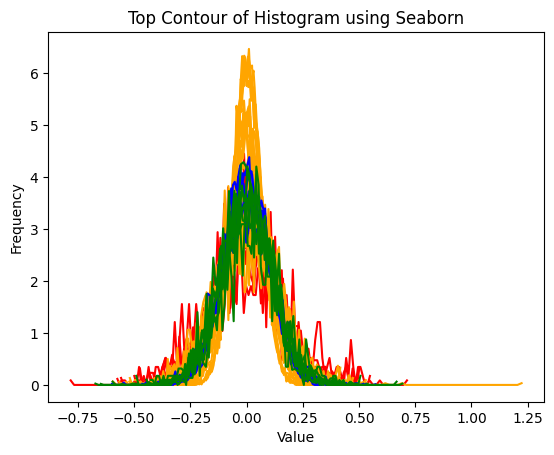

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


In [40]:
# consider all models, and no thalamus: 

weights_into_dcn = {'WT-M350':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]},
                'WT-M355':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]}, 
                'AS-M351':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]},
                'AS-M354':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>10 and df.dcn_spikes[0].shape[1]>10 and df.str_spikes[0].shape[1]>10:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                subsample_number_neurons = min([df.m1_spikes[0].shape[1], df.dcn_spikes[0].shape[1], df.str_spikes[0].shape[1]])

                if subsample_number_neurons >= 20:

                    indices_m1 = random.sample(range(df.m1_spikes[0].shape[1]), subsample_number_neurons)
                    indices_dcn = random.sample(range(df.dcn_spikes[0].shape[1]), subsample_number_neurons)
                    indices_str = random.sample(range(df.str_spikes[0].shape[1]), subsample_number_neurons)
                    for i in range(len(df)):
                        df.m1_spikes[i] = df.m1_spikes[i][:,indices_m1]
                        df.dcn_spikes[i] = df.dcn_spikes[i][:,indices_dcn]
                        df.str_spikes[i] = df.str_spikes[i][:,indices_str]



                    for col in spike_fields:
                        df = pyaldata.transform_signal(df, col,  'sqrt')

                    if animal_model=='AS-M351' or animal_model=='AS-M354':
                        number_dcn = int(np.shape(df.dcn_spikes[0])[1]/2)
                        for i in range(len(df.dcn_spikes)):
                            df.dcn_spikes[i] = df.dcn_spikes[i][:,0:number_dcn]

                    df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                    df = pyaldata.add_firing_rates(df, 'smooth')

                    df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                    # trial-average:
                    avg_all_rates = df["all_rates"].mean()
                    avg_m1_rates = df["m1_rates"].mean()
                    avg_str_rates = df["str_rates"].mean()
                    avg_dcn_rates = df["dcn_rates"].mean()

                    # prepare inputs to the RNN training function
                    activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                    Na = avg_m1_rates.shape[1]
                    Nb = avg_dcn_rates.shape[1]
                    Nc = avg_str_rates.shape[1]

                    regions = []
                    regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                    regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                    regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                    regions = np.array(regions, dtype=object)

                    model = curbd.trainMultiRegionRNN(activity,
                                    dtData=df.bin_size[0],
                                    dtFactor=5,  # interpolation factor of RNN
                                    regions=regions,
                                    nRunTrain=100,
                                    verbose=False,
                                    plotStatus=False,
                                    nRunFree=1)
                    
                    print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                    print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                    weights_into_dcn[animal_model]['m1 to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]])
                    weights_into_dcn[animal_model]['dcn to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][1][1]])
                    weights_into_dcn[animal_model]['str to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][2][1]])
                

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M350_session2.mat: 0.014681651838546184
Explained variance for  WT-M350_session2.mat: 0.9951211700654508
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
Error for  WT-M350_session5.mat: 0.01969125841731507
Explained variance for  WT-M350_session5.mat: 0.9939441912888786
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
Error for  WT-M350_session6.mat: 0.016705107558652166
Explained variance for  WT-M350_session6.mat: 0.9901047498974089
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
Error for  WT-M355_session1.mat: 0.02571553030927008
Explained variance for  WT-M355_session1.mat: 0.990402905663135
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/auti

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session11.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session12.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
Error for  WT-M355_session12.mat: 0.005495185408807855
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
Error for  WT-M355_session13.mat: 0.00763408545184274
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session15.mat
(63, 1)
(63, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
Error for  WT-M355_session15.mat: 0.02211657365812692
Explained variance for  WT-M355_session15.mat: 0.989631240856203
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M35

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session18.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
Error for  WT-M355_session18.mat: 0.006313634418331094
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
Error for  WT-M355_session19.mat: 0.01573553683246621
Explained variance for  WT-M355_session19.mat: 0.9914873198379545
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/a

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session20.mat
(60, 1)
(60, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session20.mat: 0.05130124773137812
Explained variance for  WT-M355_session20.mat: 0.9790609096293271
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M3

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
Error for  WT-M355_session21.mat: 0.017725362850220364
Explained variance for  WT-M355_session21.mat: 0.9885560656956838
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism d

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
Error for  WT-M355_session23.mat: 0.00904789509078859
Explained variance for  WT-M355_session23.mat: 0.9944950611592178
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/a

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
Error for  WT-M355_session3.mat: 0.01309232107850469
Explained variance for  WT-M355_sessio

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
Error for  WT-M355_session4.mat: 0.006976465955969089
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
Error for  WT-M355_session5.mat: 0.005739436649588201
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
Error for  WT-M355_session6.mat: 0.013347381552534052
Explained variance for  WT-M355_session6.mat: 0.990175928199895
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  WT-M355_session7.mat: 0.010288529134714753
Explained variance for  WT-M355_session7.mat: 0.9935044462086365
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session9.mat: 0.016323845862570706
Explained variance for  WT-M355_session9.mat: 0.9919284618932466
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism dat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
Error for  AS-M351_session1.mat: 0.025869345724172713
Explained variance for  AS-M351_session1.mat: 0.985185553874478
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  AS-M351_session2.mat: 0.01172935603282215
Explained variance for  AS-M351_session2.mat: 0.9964702936580753
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
Error for  AS-M351_session3.mat: 0.011559702743596374
Explained variance for  AS-M351_session3.mat: 0.9971725922037091
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
Error for  AS-M351_session4.mat: 0.012869555266698713
Explained variance for  AS-M351_session4.mat: 0.9948846666870734
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
Error for  AS-M351_session7.mat: 0.011655156787283584
Explained variance for  AS-M351_session7.mat: 0.9918843191779491
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
Error for  AS-M351_session8.mat: 0.018681639819751534
Explained variance for  AS-M351_session8.mat: 0.9919148956758517
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
Error for  AS-M354_session4.mat: 0.006597697659986179
Explained variance for  AS-M354_session4.mat: 0.9967486274029993
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
Error for  AS-M354_session5.mat: 0.005585706698913064
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
Error for  AS-M354_session6.mat: 0.006187036275385092
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
Error for  AS-M354_session7.mat: 0.010617342418692496
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3381466771.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
Error for  AS-M354_session8.mat: 0.009952758963296738
Explained variance for  AS-M354_session8.mat: 

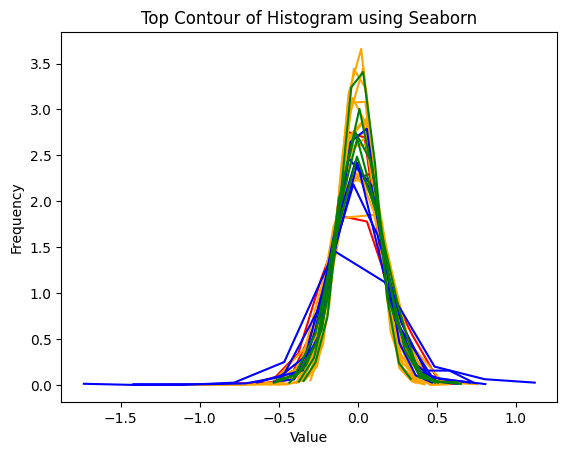

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=10, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=10, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=10, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=10, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


In [61]:
# consider all models, and no thalamus: 

weights_into_dcn = {'WT-M350':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>10 and df.dcn_spikes[0].shape[1]>10 and df.str_spikes[0].shape[1]>10:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                subsample_number_neurons = min([df.m1_spikes[0].shape[1], df.dcn_spikes[0].shape[1], df.str_spikes[0].shape[1]])

                if subsample_number_neurons >= 30:
                    subsample_number_neurons = 30

                    indices_m1 = random.sample(range(df.m1_spikes[0].shape[1]), subsample_number_neurons)
                    indices_dcn = random.sample(range(df.dcn_spikes[0].shape[1]), subsample_number_neurons)
                    indices_str = random.sample(range(df.str_spikes[0].shape[1]), subsample_number_neurons)
                    for i in range(len(df)):
                        df.m1_spikes[i] = df.m1_spikes[i][:,indices_m1]
                        df.dcn_spikes[i] = df.dcn_spikes[i][:,indices_dcn]
                        df.str_spikes[i] = df.str_spikes[i][:,indices_str]



                    for col in spike_fields:
                        df = pyaldata.transform_signal(df, col,  'sqrt')

                    if animal_model=='AS-M351' or animal_model=='AS-M354':
                        number_dcn = int(np.shape(df.dcn_spikes[0])[1]/2)
                        for i in range(len(df.dcn_spikes)):
                            df.dcn_spikes[i] = df.dcn_spikes[i][:,0:number_dcn]

                    df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                    df = pyaldata.add_firing_rates(df, 'smooth')

                    df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                    # trial-average:
                    avg_all_rates = df["all_rates"].mean()
                    avg_m1_rates = df["m1_rates"].mean()
                    avg_str_rates = df["str_rates"].mean()
                    avg_dcn_rates = df["dcn_rates"].mean()

                    # prepare inputs to the RNN training function
                    activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                    Na = avg_m1_rates.shape[1]
                    Nb = avg_dcn_rates.shape[1]
                    Nc = avg_str_rates.shape[1]

                    regions = []
                    regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                    regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                    regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                    regions = np.array(regions, dtype=object)

                    model = curbd.trainMultiRegionRNN(activity,
                                    dtData=df.bin_size[0],
                                    dtFactor=5,  # interpolation factor of RNN
                                    regions=regions,
                                    nRunTrain=100,
                                    verbose=False,
                                    plotStatus=False,
                                    nRunFree=1)
                    
                    print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                    print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))


                    weights_into_dcn[animal_model]['m1 to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][0][1]])
                    weights_into_dcn[animal_model]['dcn to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][1][1]])
                    weights_into_dcn[animal_model]['str to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][2][1]])

                    weights_into_dcn[animal_model]['m1 to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]])
                    weights_into_dcn[animal_model]['dcn to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][1][1]])
                    weights_into_dcn[animal_model]['str to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][2][1]])

                    weights_into_dcn[animal_model]['m1 to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][0][1]])
                    weights_into_dcn[animal_model]['dcn to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][1][1]])
                    weights_into_dcn[animal_model]['str to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][2][1]])
                
                

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session3.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session6.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session10.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session11.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session12.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  WT-M355_session12.mat: 0.01799517558328933
Explained variance for  WT-M355_session12.mat: 0.988383046229951
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  WT-M355_session13.mat: 0.014248851681181687
Explained variance for  WT-M355_session13.mat: 0.9874340520988439
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session15.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session17.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session18.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  WT-M355_session18.mat: 0.012722451422191092
Explained variance for  WT-M355_session18.mat: 0.9941381034201475
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session20.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session21.mat
(90, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  WT-M355_session21.mat: 0.020812619394028373
Explained variance for  WT-M355_session21.mat: 0.989210784312934
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism da

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  WT-M355_session23.mat: 0.009541156869551488
Explained variance for  WT-M355_session23.mat: 0.9918123717052667
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  WT-M355_session3.mat: 0.01978504098914883
Explained variance for  WT-M355_session3.mat: 0.9910572837925838
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  WT-M355_session4.mat: 0.010242960783044642
Explained variance for  WT-M355_session4.mat: 0.9907815122539374
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  WT-M355_session5.mat: 0.012938285868791699
Explained variance for  WT-M355_session5.mat: 0.9898136717625102
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session9.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M351_session2.mat: 0.02706183551466136
Explained variance for  AS-M351_session2.mat: 0.994281812542221
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/auti

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M351_session3.mat: 0.014075517252070636
Explained variance for  AS-M351_session3.mat: 0.9958702499318901
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2\AS-M351_session7.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M351_session7.mat: 0.033364321070521126
Explained variance for  AS-M351_session7.mat: 0.9914420272363587
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M351_session8.mat: 0.022664884575333784
Explained variance for  AS-M351_session8.mat: 0.9883976492248778
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M354_session4.mat: 0.007871015143183226
Explained variance for  AS-M354_session4.mat: 0.9956979397128101
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M354_session5.mat: 0.01758094756002835
Explained variance for  AS-M354_session5.mat: 0.9962845386625693
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M354_session6.mat: 0.013335106837610487
Explained variance for  AS-M354_session6.mat: 0.9938838579680009
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M354_session7.mat: 0.018379460197500547
Explained variance for  AS-M354_session7.mat: 0.9927452593647743
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\1384477353.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  AS-M354_session8.mat: 0.021825974266591476
Explained variance for  AS-M354_session8.mat: 0.9901021577738394


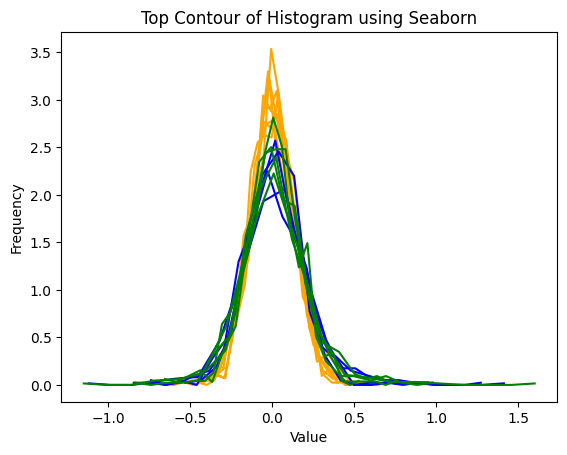

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


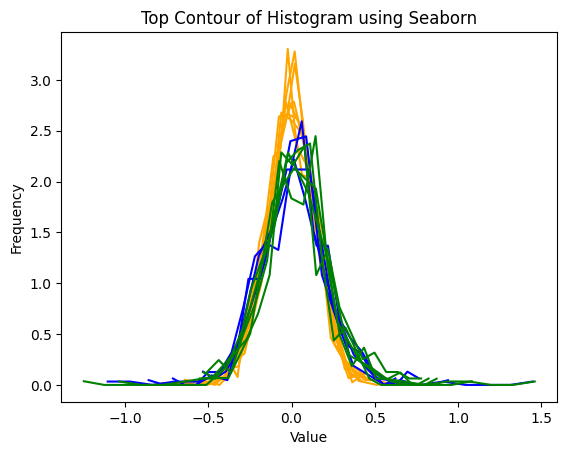

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


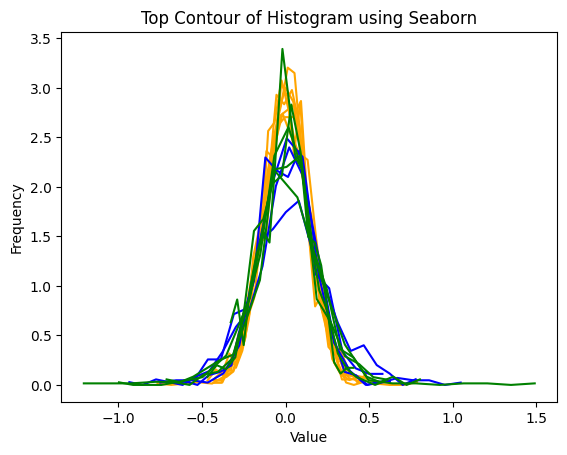

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


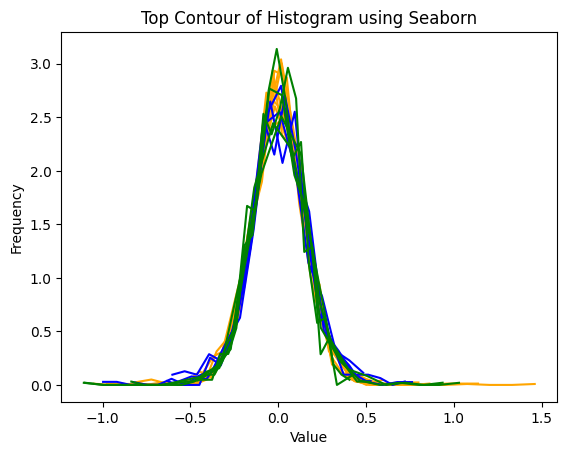

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


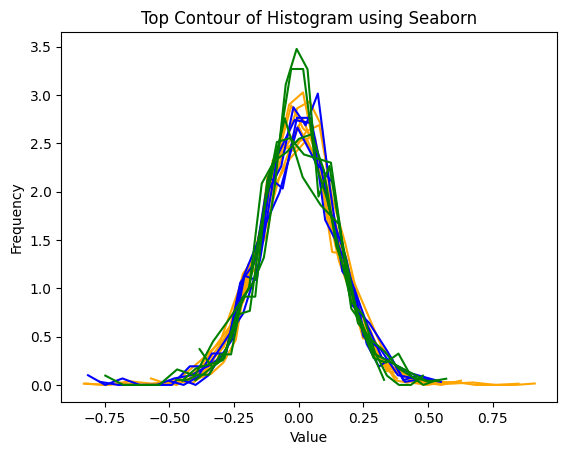

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


In [79]:
# consider all models, and no thalamus: 

weights_into_dcn = {'WT-M350':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>10 and df.dcn_spikes[0].shape[1]>10 and df.str_spikes[0].shape[1]>10:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                subsample_number_neurons = min([df.m1_spikes[0].shape[1], df.dcn_spikes[0].shape[1], df.str_spikes[0].shape[1]])

                if subsample_number_neurons >= 20:
                    subsample_number_neurons = 20

                    indices_m1 = random.sample(range(df.m1_spikes[0].shape[1]), subsample_number_neurons)
                    indices_dcn = random.sample(range(df.dcn_spikes[0].shape[1]), subsample_number_neurons)
                    indices_str = random.sample(range(df.str_spikes[0].shape[1]), subsample_number_neurons)
                    for i in range(len(df)):
                        df.m1_spikes[i] = df.m1_spikes[i][:,indices_m1]
                        df.dcn_spikes[i] = df.dcn_spikes[i][:,indices_dcn]
                        df.str_spikes[i] = df.str_spikes[i][:,indices_str]



                    for col in spike_fields:
                        df = pyaldata.transform_signal(df, col,  'sqrt')

                    if animal_model=='AS-M351' or animal_model=='AS-M354':
                        number_dcn = int(np.shape(df.dcn_spikes[0])[1]/2)
                        for i in range(len(df.dcn_spikes)):
                            df.dcn_spikes[i] = df.dcn_spikes[i][:,0:number_dcn]

                    df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                    df = pyaldata.add_firing_rates(df, 'smooth')

                    df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                    # trial-average:
                    avg_all_rates = df["all_rates"].mean()
                    avg_m1_rates = df["m1_rates"].mean()
                    avg_str_rates = df["str_rates"].mean()
                    avg_dcn_rates = df["dcn_rates"].mean()

                    # prepare inputs to the RNN training function
                    activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                    Na = avg_m1_rates.shape[1]
                    Nb = avg_dcn_rates.shape[1]
                    Nc = avg_str_rates.shape[1]

                    regions = []
                    regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                    regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                    regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                    regions = np.array(regions, dtype=object)

                    model = curbd.trainMultiRegionRNN(activity,
                                    dtData=df.bin_size[0],
                                    dtFactor=5,  # interpolation factor of RNN
                                    regions=regions,
                                    nRunTrain=100,
                                    verbose=False,
                                    plotStatus=False,
                                    nRunFree=1)
                    
                    print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                    print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))


                    weights_into_dcn[animal_model]['m1 to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][0][1]])
                    weights_into_dcn[animal_model]['dcn to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][1][1]])
                    weights_into_dcn[animal_model]['str to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][2][1]])

                    weights_into_dcn[animal_model]['m1 to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]])
                    weights_into_dcn[animal_model]['dcn to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][1][1]])
                    weights_into_dcn[animal_model]['str to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][2][1]])

                    weights_into_dcn[animal_model]['m1 to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][0][1]])
                    weights_into_dcn[animal_model]['dcn to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][1][1]])
                    weights_into_dcn[animal_model]['str to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][2][1]])
                
                

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M350_session2.mat: 0.022763685117327476
Explained variance for  WT-M350_session2.mat: 0.9919307316739313
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M350_session5.mat: 0.03176590346092867
Explained variance for  WT-M350_session5.mat: 0.9912453068158009
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M350_session6.mat: 0.03517141516164373
Explained variance for  WT-M350_session6.mat: 0.9842929719301227
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session1.mat: 0.038570944245860446
Explained variance for  WT-M355_session1.mat: 0.9872044241041305
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session11.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session12.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session12.mat: 0.026473838303652287
Explained variance for  WT-M355_session12.mat: 0.9902389889707178
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session13.mat: 0.039666368238596685
Explained variance for  WT-M355_session13.mat: 0.9803824208913955
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session15.mat
(60, 1)
(60, 1)
(60, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session15.mat: 0.0287482765121848
Explained variance for  WT-M355_session15.mat: 0.9853658733960277
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M35

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session18.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session18.mat: 0.02802244894832131
Explained variance for  WT-M355_session18.mat: 0.9887264801862131
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/a

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session19.mat: 0.01802540738342765
Explained variance for  WT-M355_session19.mat: 0.9927995619446489
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/a

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session20.mat
(60, 1)
(60, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session20.mat: 0.04544566374100456
Explained variance for  WT-M355_session20.mat: 0.9823125456166308
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M3

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session21.mat: 0.05685422654984322
Explained variance for  WT-M355_session21.mat: 0.9752744711364144
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M3

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session23.mat: 0.015221515141354027
Explained variance for  WT-M355_session23.mat: 0.9945823806233719
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session3.mat: 0.05409711360663909
Explained variance for  WT-M355_session3.mat: 0.9750562543980941
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session4.mat: 0.08052987945912378
Explained variance for  WT-M355_session4.mat: 0.9656650037938128
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session5.mat: 0.021313826811894032
Explained variance for  WT-M355_session5.mat: 0.98995177560075
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/auti

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session6.mat: 0.026919201040609343
Explained variance for  WT-M355_session6.mat: 0.9861153378090024
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session7.mat: 0.01273244791762037
Explained variance for  WT-M355_session7.mat: 0.9942084439284115
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session9.mat: 0.01744438200881589
Explained variance for  WT-M355_session9.mat: 0.9927389293370029
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M351_session1.mat: 0.04974035680712841
Explained variance for  AS-M351_session1.mat: 0.9849450986421322
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M351_session2.mat: 0.042088807945092024
Explained variance for  AS-M351_session2.mat: 0.9904369689227274
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M351_session3.mat: 0.025404963005938697
Explained variance for  AS-M351_session3.mat: 0.9940080809392272
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M351_session4.mat: 0.016402058221331117
Explained variance for  AS-M351_session4.mat: 0.9943462208033695
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M351_session7.mat: 0.04205588016181257
Explained variance for  AS-M351_session7.mat: 0.9845684145587174
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M351_session8.mat: 0.025153624158198253
Explained variance for  AS-M351_session8.mat: 0.9851609034505577
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M354_session4.mat: 0.018135818870343275
Explained variance for  AS-M354_session4.mat: 0.9932951657544298
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M354_session5.mat: 0.031254988975454194
Explained variance for  AS-M354_session5.mat: 0.98628059398225
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/auti

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M354_session6.mat: 0.04892384777876199
Explained variance for  AS-M354_session6.mat: 0.9908216910712159
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M354_session7.mat: 0.04630134254506973
Explained variance for  AS-M354_session7.mat: 0.9905757388455401
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\4097259871.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
(50, 1)
Error for  AS-M354_session8.mat: 0.07028037913823638
Explained variance for  AS-M354_session8.mat: 0.9852433447517862


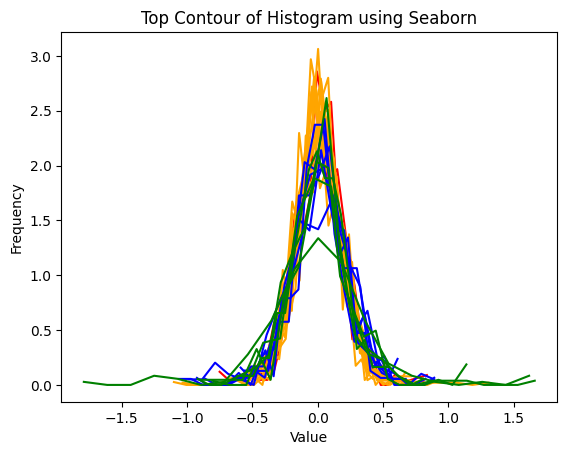

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


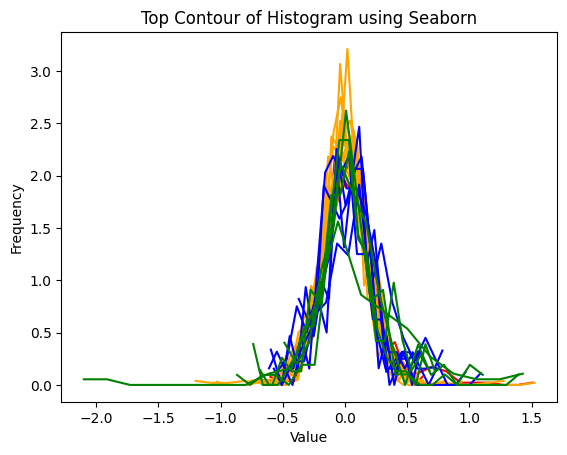

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


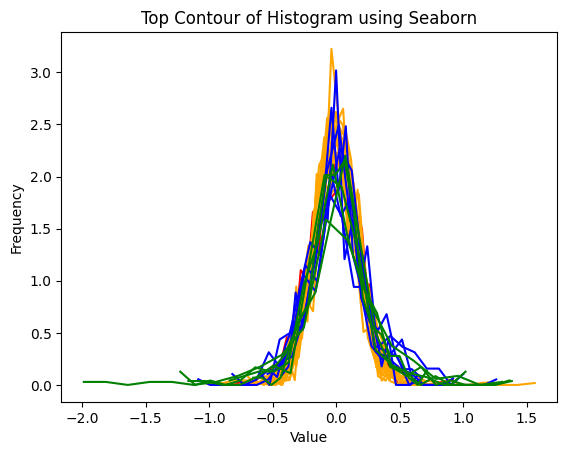

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


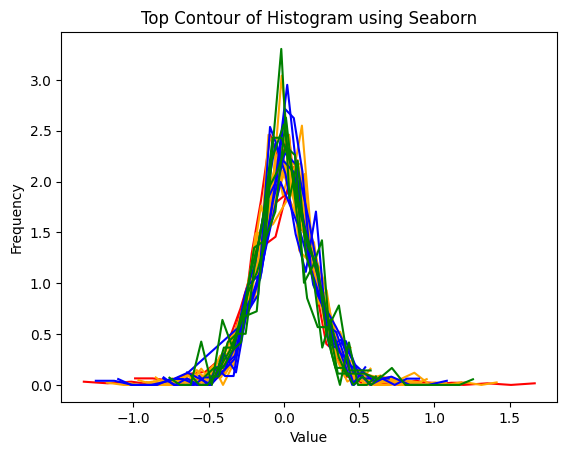

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


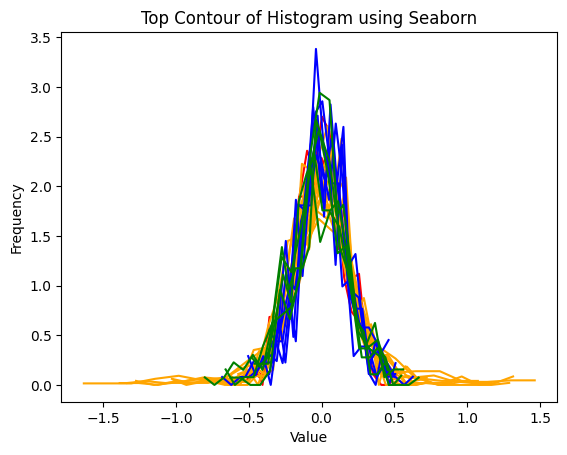

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=20, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


In [71]:
# consider all models, and no thalamus: 

weights_into_dcn = {'WT-M350':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]},
                'WT-M355':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]}, 
                'AS-M351':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]},
                'AS-M354':{'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>10 and df.dcn_spikes[0].shape[1]>10 and df.str_spikes[0].shape[1]>10:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                subsample_number_neurons = min([df.m1_spikes[0].shape[1], df.dcn_spikes[0].shape[1], df.str_spikes[0].shape[1]])

                if subsample_number_neurons >= 20:

                    indices_m1 = random.sample(range(df.m1_spikes[0].shape[1]), subsample_number_neurons)
                    indices_dcn = random.sample(range(df.dcn_spikes[0].shape[1]), subsample_number_neurons)
                    indices_str = random.sample(range(df.str_spikes[0].shape[1]), subsample_number_neurons)
                    for i in range(len(df)):
                        df.m1_spikes[i] = df.m1_spikes[i][:,indices_m1]
                        df.dcn_spikes[i] = df.dcn_spikes[i][:,indices_dcn]
                        df.str_spikes[i] = df.str_spikes[i][:,indices_str]



                    for col in spike_fields:
                        df = pyaldata.transform_signal(df, col,  'sqrt')

                    if animal_model=='AS-M351' or animal_model=='AS-M354':
                        number_dcn = int(np.shape(df.dcn_spikes[0])[1]/2)
                        for i in range(len(df.dcn_spikes)):
                            df.dcn_spikes[i] = df.dcn_spikes[i][:,0:number_dcn]

                    df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                    df = pyaldata.add_firing_rates(df, 'smooth')

                    df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                    # trial-average:
                    avg_all_rates = df["all_rates"].mean()
                    avg_m1_rates = df["m1_rates"].mean()
                    avg_str_rates = df["str_rates"].mean()
                    avg_dcn_rates = df["dcn_rates"].mean()

                    # prepare inputs to the RNN training function
                    activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                    Na = avg_m1_rates.shape[1]
                    Nb = avg_dcn_rates.shape[1]
                    Nc = avg_str_rates.shape[1]

                    regions = []
                    regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                    regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                    regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                    regions = np.array(regions, dtype=object)

                    model = curbd.trainMultiRegionRNN(activity,
                                    dtData=df.bin_size[0],
                                    dtFactor=5,  # interpolation factor of RNN
                                    regions=regions,
                                    nRunTrain=100,
                                    verbose=False,
                                    plotStatus=False,
                                    nRunFree=1)
                    
                    print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                    print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))
                

                

                
                    [curbd_arr, curbd_labels] = curbd.computeCURBD(model)

                    magn_m1tom1 = sum(abs(curbd_arr[0][0]))
                    baseline_m1tom1 = np.mean(magn_m1tom1[0:250])
                    strength_m1tom1 = math.sqrt(sum(np.power(((magn_m1tom1[250:500]-baseline_m1tom1)/baseline_m1tom1),2))/250)
                    current_magn_strengths[animal_model]['m1 to m1'].append(strength_m1tom1)

                    magn_dcntom1 = sum(abs(curbd_arr[0][1]))
                    baseline_dcntom1 = np.mean(magn_dcntom1[0:250])
                    strength_dcntom1 = math.sqrt(sum(np.power(((magn_dcntom1[250:500]-baseline_dcntom1)/baseline_dcntom1),2))/250)
                    current_magn_strengths[animal_model]['dcn to m1'].append(strength_dcntom1)

                    magn_strtom1 = sum(abs(curbd_arr[0][2]))
                    baseline_strtom1 = np.mean(magn_strtom1[0:250])
                    strength_strtom1 = math.sqrt(sum(np.power(((magn_strtom1[250:500]-baseline_strtom1)/baseline_strtom1),2))/250)
                    current_magn_strengths[animal_model]['str to m1'].append(strength_strtom1)

                    magn_m1todcn = sum(abs(curbd_arr[1][0]))
                    baseline_m1todcn = np.mean(magn_m1todcn[0:250])
                    strength_m1todcn = math.sqrt(sum(np.power(((magn_m1todcn[250:500]-baseline_m1todcn)/baseline_m1todcn),2))/250)
                    current_magn_strengths[animal_model]['m1 to dcn'].append(strength_m1todcn)

                    magn_dcntodcn = sum(abs(curbd_arr[1][1]))
                    baseline_dcntodcn = np.mean(magn_dcntodcn[0:250])
                    strength_dcntodcn = math.sqrt(sum(np.power(((magn_dcntodcn[250:500]-baseline_dcntodcn)/baseline_dcntodcn),2))/250)
                    current_magn_strengths[animal_model]['dcn to dcn'].append(strength_dcntodcn)

                    magn_strtodcn = sum(abs(curbd_arr[1][2]))
                    baseline_strtodcn = np.mean(magn_strtodcn[0:250])
                    strength_strtodcn = math.sqrt(sum(np.power(((magn_strtodcn[250:500]-baseline_strtodcn)/baseline_strtodcn),2))/250)
                    current_magn_strengths[animal_model]['str to dcn'].append(strength_strtodcn)

                    magn_m1tostr = sum(abs(curbd_arr[2][0]))
                    baseline_m1tostr = np.mean(magn_m1tostr[0:250])
                    strength_m1tostr = math.sqrt(sum(np.power(((magn_m1tostr[250:500]-baseline_m1tostr)/baseline_m1tostr),2))/250)
                    current_magn_strengths[animal_model]['m1 to str'].append(strength_m1tostr)

                    magn_dcntostr = sum(abs(curbd_arr[2][1]))
                    baseline_dcntostr = np.mean(magn_dcntostr[0:250])
                    strength_dcntostr = math.sqrt(sum(np.power(((magn_dcntostr[250:500]-baseline_dcntostr)/baseline_dcntostr),2))/250)
                    current_magn_strengths[animal_model]['dcn to str'].append(strength_dcntostr)

                    magn_strtostr = sum(abs(curbd_arr[2][2]))
                    baseline_strtostr = np.mean(magn_strtostr[0:250])
                    strength_strtostr = math.sqrt(sum(np.power(((magn_strtostr[250:500]-baseline_strtostr)/baseline_strtostr),2))/250)
                    current_magn_strengths[animal_model]['str to str'].append(strength_strtostr)


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M350_session2.mat: 0.03351300420904913
Explained variance for  WT-M350_session2.mat: 0.9919593660483809
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session5.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
(81, 1)
Error for  WT-M350_session5.mat: 0.014945852920894884
Explained variance for  WT-M350_session5.mat: 0.9948622272953711
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
(78, 1)
Error for  WT-M350_session6.mat: 0.02405107205884033
Explained variance for  WT-M350_session6.mat: 0.988008014044952
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/auti

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
Error for  WT-M355_session1.mat: 0.015330283868570948
Explained variance for  WT-M355_session1.mat: 0.9828284838519107
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session11.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session12.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
(144, 1)
Error for  WT-M355_session12.mat: 0.0072973589507420375
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
Error for  WT-M355_session13.mat: 0.0060596966584613
Explained variance for  WT-M355_sessio

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session15.mat
(63, 1)
(63, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
Error for  WT-M355_session15.mat: 0.03016242014060867
Explained variance for  WT-M355_session15.mat: 0.9838245819027286
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M3

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session18.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
Error for  WT-M355_session18.mat: 0.0051644728709806815
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
Error for  WT-M355_session19.mat: 0.008381337371475056
Explained variance for  WT-M355_session19.mat: 0.9930497805263351
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2\WT-M355_session20.mat
(60, 1)
(60, 1)
(60, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session20.mat: 0.02949856508216684
Explained variance for  WT-M355_session20.mat: 0.9811516808250352
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M3

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
(96, 1)
Error for  WT-M355_session21.mat: 0.01854896437533112
Explained variance for  WT-M355_session21.mat: 0.9879701485540063
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism da

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
(99, 1)
Error for  WT-M355_session23.mat: 0.009097638285758991
Explained variance for  WT-M355_session23.mat: 0.9943769001547124
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
(114, 1)
Error for  WT-M355_session3.mat: 0.008685942023934724
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
(135, 1)
Error for  WT-M355_session4.mat: 0.005891659692938919
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)
Error for  WT-M355_session5.mat: 0.006302584803686873
Explained variance for  WT-M355_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
Error for  WT-M355_session6.mat: 0.016751025803142226
Explained variance for  WT-M355_session6.mat: 0.9899912361617411
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
(75, 1)
Error for  WT-M355_session7.mat: 0.017526602818407712
Explained variance for  WT-M355_session7.mat: 0.9918828985675797
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
(60, 1)
Error for  WT-M355_session9.mat: 0.028989180851607798
Explained variance for  WT-M355_session9.mat: 0.9866506731492966
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M35

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
Error for  AS-M351_session1.mat: 0.03879785891437635
Explained variance for  AS-M351_session1.mat: 0.9828951967454724
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
(90, 1)
Error for  AS-M351_session2.mat: 0.013560775553108693
Explained variance for  AS-M351_session2.mat: 0.9959581836664355
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
Error for  AS-M351_session3.mat: 0.009149709589031201
Explained variance for  AS-M351_session3.mat: 0.9966295387294356
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
(57, 1)
Error for  AS-M351_session4.mat: 0.02021959583807684
Explained variance for  AS-M351_session4.mat: 0.9954382851803638
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
(97, 1)
Error for  AS-M351_session7.mat: 0.015679088055324853
Explained variance for  AS-M351_session7.mat: 0.990385583261132
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/aut

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
Error for  AS-M351_session8.mat: 0.014418161286366991
Explained variance for  AS-M351_session8.mat: 0.9924321285830118
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session2.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2\AS-M354_session4.mat


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
(92, 1)
Error for  AS-M354_session4.mat: 0.009597802196940734
Explained variance for  AS-M354_session4.mat: 0.9970633740098267
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
(152, 1)
Error for  AS-M354_session5.mat: 0.00485640460775594
Explained variance for  AS-M354_sessio

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
Error for  AS-M354_session6.mat: 0.005800261132232332
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
(102, 1)
Error for  AS-M354_session7.mat: 0.008881689640500975
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_11872\3331756561.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
(112, 1)
Error for  AS-M354_session8.mat: 0.0091821254232253
Explained variance for  AS-M354_session8.mat: 0.

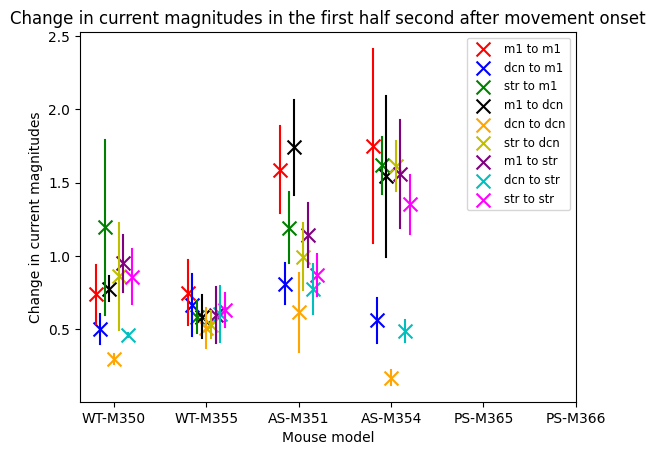

In [78]:
import statistics

# Using mean and standard deviation (obs: need normal distribution)

current_list = ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']
colors_list = ['r','b','g','k','orange','y','purple','c','magenta']
i = 1

handles = []
for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354']:
    current_index = 0
    for current in current_list:
        #plt.scatter(i*np.ones(len(current_magn_strengths[animal_model][current])),current_magn_strengths[animal_model][current], color=colors_list[current_index], s=10)  # or should we plot the median for each session instead of mean?
        handle = plt.scatter(i,statistics.mean(current_magn_strengths[animal_model][current]), color=colors_list[current_index], marker='x', s=100)  # median of average (mean) duration of movement execution for each session
        plt.plot([i,i], [statistics.mean(current_magn_strengths[animal_model][current])-statistics.stdev(current_magn_strengths[animal_model][current])/2,statistics.mean(current_magn_strengths[animal_model][current])+statistics.stdev(current_magn_strengths[animal_model][current])/2], color=colors_list[current_index])
        current_index +=1
        i +=1
        handles.append(handle)
    i +=11

plt.xticks([5,25,45,65,85,105],['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366'])
plt.xlabel('Mouse model')
plt.ylabel('Change in current magnitudes')
plt.title('Change in current magnitudes in the first half second after movement onset')
plt.legend(handles[0:9], current_list, fontsize='small')

In [36]:
import random

# Create a list of 100 elements
numbers = list(range(1, 40))

# Select 20 random numbers from the list
random_numbers = random.sample(numbers, 20)

print(random_numbers)


[2, 23, 7, 6, 33, 8, 30, 5, 26, 37, 14, 21, 1, 10, 16, 39, 15, 38, 31, 18]


In [35]:
np.shape(df.m1_rates[0])

(151, 47)

In [38]:
np.shape(df.m1_rates[0][:,random_numbers])
df.m1_rates[0]

(151, 20)

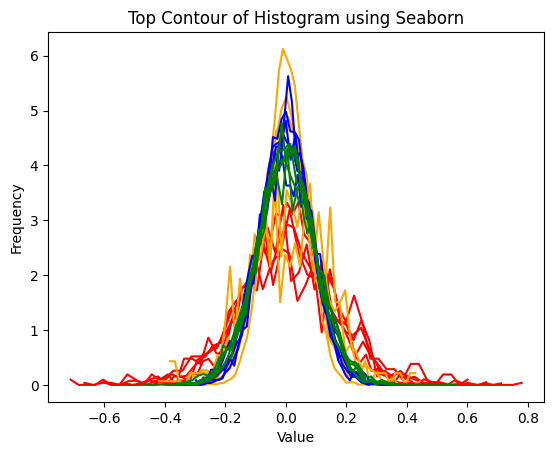

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["str to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["str to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["str to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["str to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


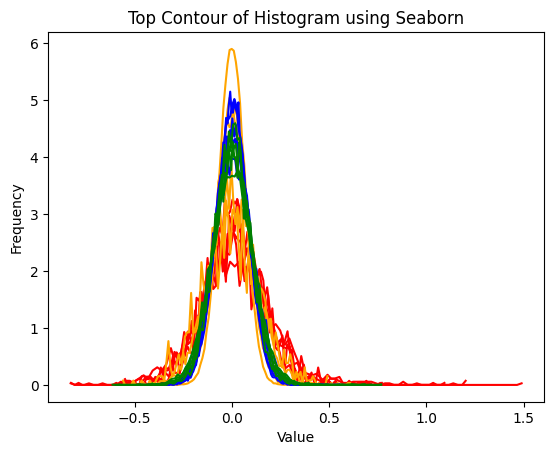

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["dcn to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()
